# Quality Assessment of Red Wine - Analysis and arrival delay prediction.
#### By: Swati Kohli

Red wine quality data set is used. The details can be found here:  
https://www.kaggle.com/abhishekmamidi/introduction-to-regression-complete-analysis

One important usage of **decision tree** (and random forest, to be discussed later) is to determine the important predictors. A predictor is considered important if it increases the predictive power of the model. Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. (source: https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

The goal is to use the predictors to predict the wine quality. Let's extract the predictors and response.

In [1]:
import pandas as pd
import numpy as np

In [2]:
wine = pd.read_csv('Data_winequality_red.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
X = wine.drop('quality', axis = 1)
y = wine.quality
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


Split into training and testing set, using randomized search to find the best parameters.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Set up pipeline and randomized search
# no pipeline coz no scaling


decision_tree =  DecisionTreeClassifier() # There is no preprocessing, so we just have one input

paras = {'max_depth': randint(2,50), # Since there's no other process in the pipeline, we don't need the name of the process
        'max_leaf_nodes': randint(2,50), # Discrete uniform distribution between 2 and 50
        'criterion': ['gini', 'entropy']}

clf_random = RandomizedSearchCV(decision_tree, paras, n_jobs = -1, cv = 5, n_iter = 100, random_state = 10) # We will randomly sample 100 different pairs
clf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CD50A4C8C8>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CD50AA9808>},
                   random_state=10)

In [5]:
# The best parameters
clf_random.best_params_

{'criterion': 'gini', 'max_depth': 48, 'max_leaf_nodes': 34}

In [6]:
# Accuracy on the test set
np.mean(clf_random.predict(X_test) == y_test)

0.6

In [7]:
# Let's look at the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf_random.predict(X_test), labels=[3,4,5,6,7,8])

array([[  0,   0,   1,   0,   0,   0],
       [  0,   0,  14,   2,   0,   0],
       [  0,   0, 148,  22,   1,   0],
       [  0,   0,  81,  75,  11,   0],
       [  0,   0,   6,  19,  17,   0],
       [  0,   0,   0,   2,   1,   0]], dtype=int64)

The accuracy is so low because the classes are quite unbalanced.

let's see if there's any difference if we use grid search.

In [8]:
paras = {'max_depth': range(2,50), # Since there's no other process in the pipeline, we don't need the name of the process
        'max_leaf_nodes': range(2,50), # Discrete uniform distribution between 2 and 50
        'criterion': ['gini', 'entropy']}


clf_grid = GridSearchCV(decision_tree, paras, n_jobs = -1, cv = 5)
clf_grid.fit(X_train, y_train)
np.mean(clf_grid.predict(X_test) == y_test)

0.6075

The results are same

Similar to logistic regression, the response variable doesn't have to be of numerical type. You can input string type response and it will able to perform the classification. Let's look at the important predictors.

In [9]:
# Refit the two models

random = DecisionTreeClassifier(max_depth = clf_random.best_params_['max_depth'],
                      max_leaf_nodes = clf_random.best_params_['max_leaf_nodes'],
                      criterion = clf_random.best_params_['criterion'])

grid = DecisionTreeClassifier(max_depth = clf_grid.best_params_['max_depth'],
                      max_leaf_nodes = clf_grid.best_params_['max_leaf_nodes'],
                      criterion = clf_grid.best_params_['criterion'])

# Fit the models
random.fit(X_train, y_train)
grid.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=32)

In [10]:
importance = pd.DataFrame({'feature':X_train.columns.values, 'randomsearch':random.feature_importances_,
                          'gridsearch': grid.feature_importances_})
importance.sort_values(by = 'randomsearch', ascending = False)

,feature,randomsearch,gridsearch
10,alcohol,0.386441,0.398452
9,sulphates,0.174615,0.180042
6,total sulfur dioxide,0.130226,0.120133
1,volatile acidity,0.101685,0.104846
3,residual sugar,0.069658,0.071823
5,free sulfur dioxide,0.045054,0.046454
7,density,0.043069,0.027467
4,chlorides,0.018455,0.019028
0,fixed acidity,0.015791,0.016282
8,pH,0.015006,0.015472


Both methods agree with the top 5 predictors. Lastly, let's plot the tree. We will just plot the randomized searched tree.

[Text(116.10823170731707, 205.35999999999999, 'X[10] <= 10.525\ngini = 0.646\nsamples = 1199\nvalue = [9, 37, 510, 471, 157, 15]'),
 Text(40.829268292682926, 181.2, 'X[9] <= 0.575\ngini = 0.546\nsamples = 727\nvalue = [6, 23, 425, 240, 31, 2]'),
 Text(24.49756097560976, 157.04, 'X[10] <= 10.15\ngini = 0.43\nsamples = 291\nvalue = [3, 15, 211, 59, 3, 0]'),
 Text(16.33170731707317, 132.88, 'gini = 0.382\nsamples = 256\nvalue = [2, 13, 196, 44, 1, 0]'),
 Text(32.66341463414634, 132.88, 'gini = 0.625\nsamples = 35\nvalue = [1, 2, 15, 15, 2, 0]'),
 Text(57.1609756097561, 157.04, 'X[6] <= 81.5\ngini = 0.582\nsamples = 436\nvalue = [3, 8, 214, 181, 28, 2]'),
 Text(48.99512195121952, 132.88, 'X[1] <= 0.535\ngini = 0.594\nsamples = 367\nvalue = [3, 7, 155, 173, 27, 2]'),
 Text(16.33170731707317, 108.72, 'X[9] <= 0.655\ngini = 0.591\nsamples = 191\nvalue = [1, 2, 60, 104, 22, 2]'),
 Text(8.165853658536586, 84.56, 'gini = 0.559\nsamples = 77\nvalue = [0, 0, 36, 36, 5, 0]'),
 Text(24.4975609756097

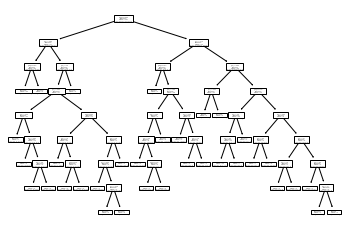

In [13]:
from sklearn import tree
from sklearn.tree import export_graphviz

tree.plot_tree(random)

[Text(167.4, 181.2, 'alcohol <= 10.525\ngini = 0.646\nsamples = 1199\nvalue = [9, 37, 510, 471, 157, 15]'),
 Text(83.7, 108.72, 'sulphates <= 0.575\ngini = 0.546\nsamples = 727\nvalue = [6, 23, 425, 240, 31, 2]'),
 Text(41.85, 36.23999999999998, 'gini = 0.43\nsamples = 291\nvalue = [3, 15, 211, 59, 3, 0]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.582\nsamples = 436\nvalue = [3, 8, 214, 181, 28, 2]'),
 Text(251.10000000000002, 108.72, 'volatile acidity <= 0.375\ngini = 0.655\nsamples = 472\nvalue = [3, 14, 85, 231, 126, 13]'),
 Text(209.25, 36.23999999999998, 'gini = 0.625\nsamples = 152\nvalue = [0, 1, 19, 57, 71, 4]'),
 Text(292.95, 36.23999999999998, 'gini = 0.63\nsamples = 320\nvalue = [3, 13, 66, 174, 55, 9]')]

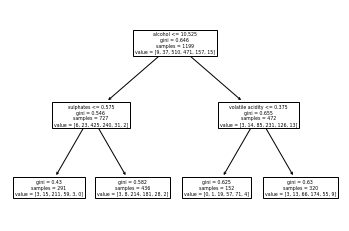

In [12]:
# Let's fit a smaller tree so we can see the plot better


small_clf = DecisionTreeClassifier(max_depth = 2, random_state = 1)
small_clf.fit(X_train, y_train)
tree.plot_tree(small_clf, feature_names=X_train.columns.values)